# Homework05: MNIST Deep Convolutional GAN to Generate MNIST digits

In [1]:
import numpy
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Input
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Conv2DTranspose
from tensorflow.keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from tqdm.notebook import tqdm

from scipy import stats
# fix random seed for reproducibility
numpy.random.seed(1)

#### Homework 05

1. Adapt the MNIST GAN implementation (see Lab09) to build CNN models instead of feedforwards.
2. Try different noise dimensions
3. Try implementing some training tricks suggested in https://github.com/soumith/ganhacks and study incremental improvements.

#### Load Data


In [3]:
import tensorflow
from tensorflow.keras.datasets.mnist import load_data
(X_train, Y_train), (X_test ,Y_test) = load_data()


def preprocess(data):
    result = (data - np.min(data)) / (np.max(data) - np.min(data))
    return np.expand_dims(result, axis=-1)


X_train = preprocess(X_train)
X_test = preprocess(X_test)

z_dim = 100

#### Summarize the data

In [4]:
print('Train', X_train.shape, Y_train.shape) #Train (60000, 28, 28) (60000,)
print('Test', X_test.shape, Y_test.shape) #Test (10000, 28, 28) (10000,)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


#### Build model

In [7]:
#GENERATOR
g = Sequential([
Dense(7 * 7 * 128, input_shape=(z_dim,)),
Reshape([7, 7, 128]),
BatchNormalization(),
Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",activation="selu"),
BatchNormalization(),
Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",activation="tanh")
])

g.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])


#DISCRIMINATOR
d = Sequential([
Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[28, 28, 1]), Dropout(0.4),
Conv2D(128, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.2)), Dropout(0.4),Flatten(),
Dense(1, activation="sigmoid")
])


opt = Adam(learning_rate=0.01)
d.compile(loss="binary_crossentropy", optimizer=opt)



#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer='SGD')

#### Visualization

In [8]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Train the model

In [13]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Generate the images from the noise
            
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))

            # Create Y labels similar to last exercise.
            y1 = np.zeros(2*BATCH_SIZE)
            y1[:BATCH_SIZE] =1 

            # Train gan and disrciminator similar to last exercise.
            ##YOUR CODE HERE###
            d.trainable = True
            d_loss = d.train_on_batch(X, y1)
            
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            
        
        print('test')
        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

--------------- Epoch 1 ---------------


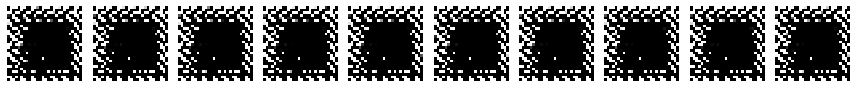

--------------- Epoch 40 ---------------


In [ ]:
train(epochs=100, plt_frq=40, BATCH_SIZE=128)